<a href="https://colab.research.google.com/github/Daishinkan002/Sentiment-Analysis-of-Marathi-Tweets/blob/main/marathi_sentiment_m_bert_bilstm_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
import os
import re
import string
from tqdm import tqdm
import pandas as pd
import tensorflow as tf
from multiprocessing import Pool
import numpy as np
import pickle
os.system('pip install -qq transformers')
os.system('pip install -q -U watermark')
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from transformers import AutoModel, AutoTokenizer
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

numpy       : 1.26.4
pandas      : 2.1.4
torch       : 2.4.0+cu121
transformers: 4.42.4



# Dataset Loading

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
df_train = pd.read_csv('/content/gdrive/MyDrive/OriginalTelgu/Telugu_Train.csv')
df_test = pd.read_csv('/content/gdrive/MyDrive/OriginalTelgu/Telugu_Test.csv')
df_valid = pd.read_csv('/content/gdrive/MyDrive/OriginalTelgu/Telugu_Valid.csv')


# df_train = pd.read_pickle('/content/gdrive/MyDrive/Major_Project/Marathi-Sentiment/Refined_Dataset/marathi_train.pkl')
# df_test = pd.read_pickle('/content/gdrive/MyDrive/Major_Project/Marathi-Sentiment/Refined_Dataset/marathi_test.pkl')
# df_valid = pd.read_pickle('/content/gdrive/MyDrive/Major_Project/Marathi-Sentiment/Refined_Dataset/marathi_valid.pkl')

# Data analysis

Text(0.5, 0, 'Sentiment')

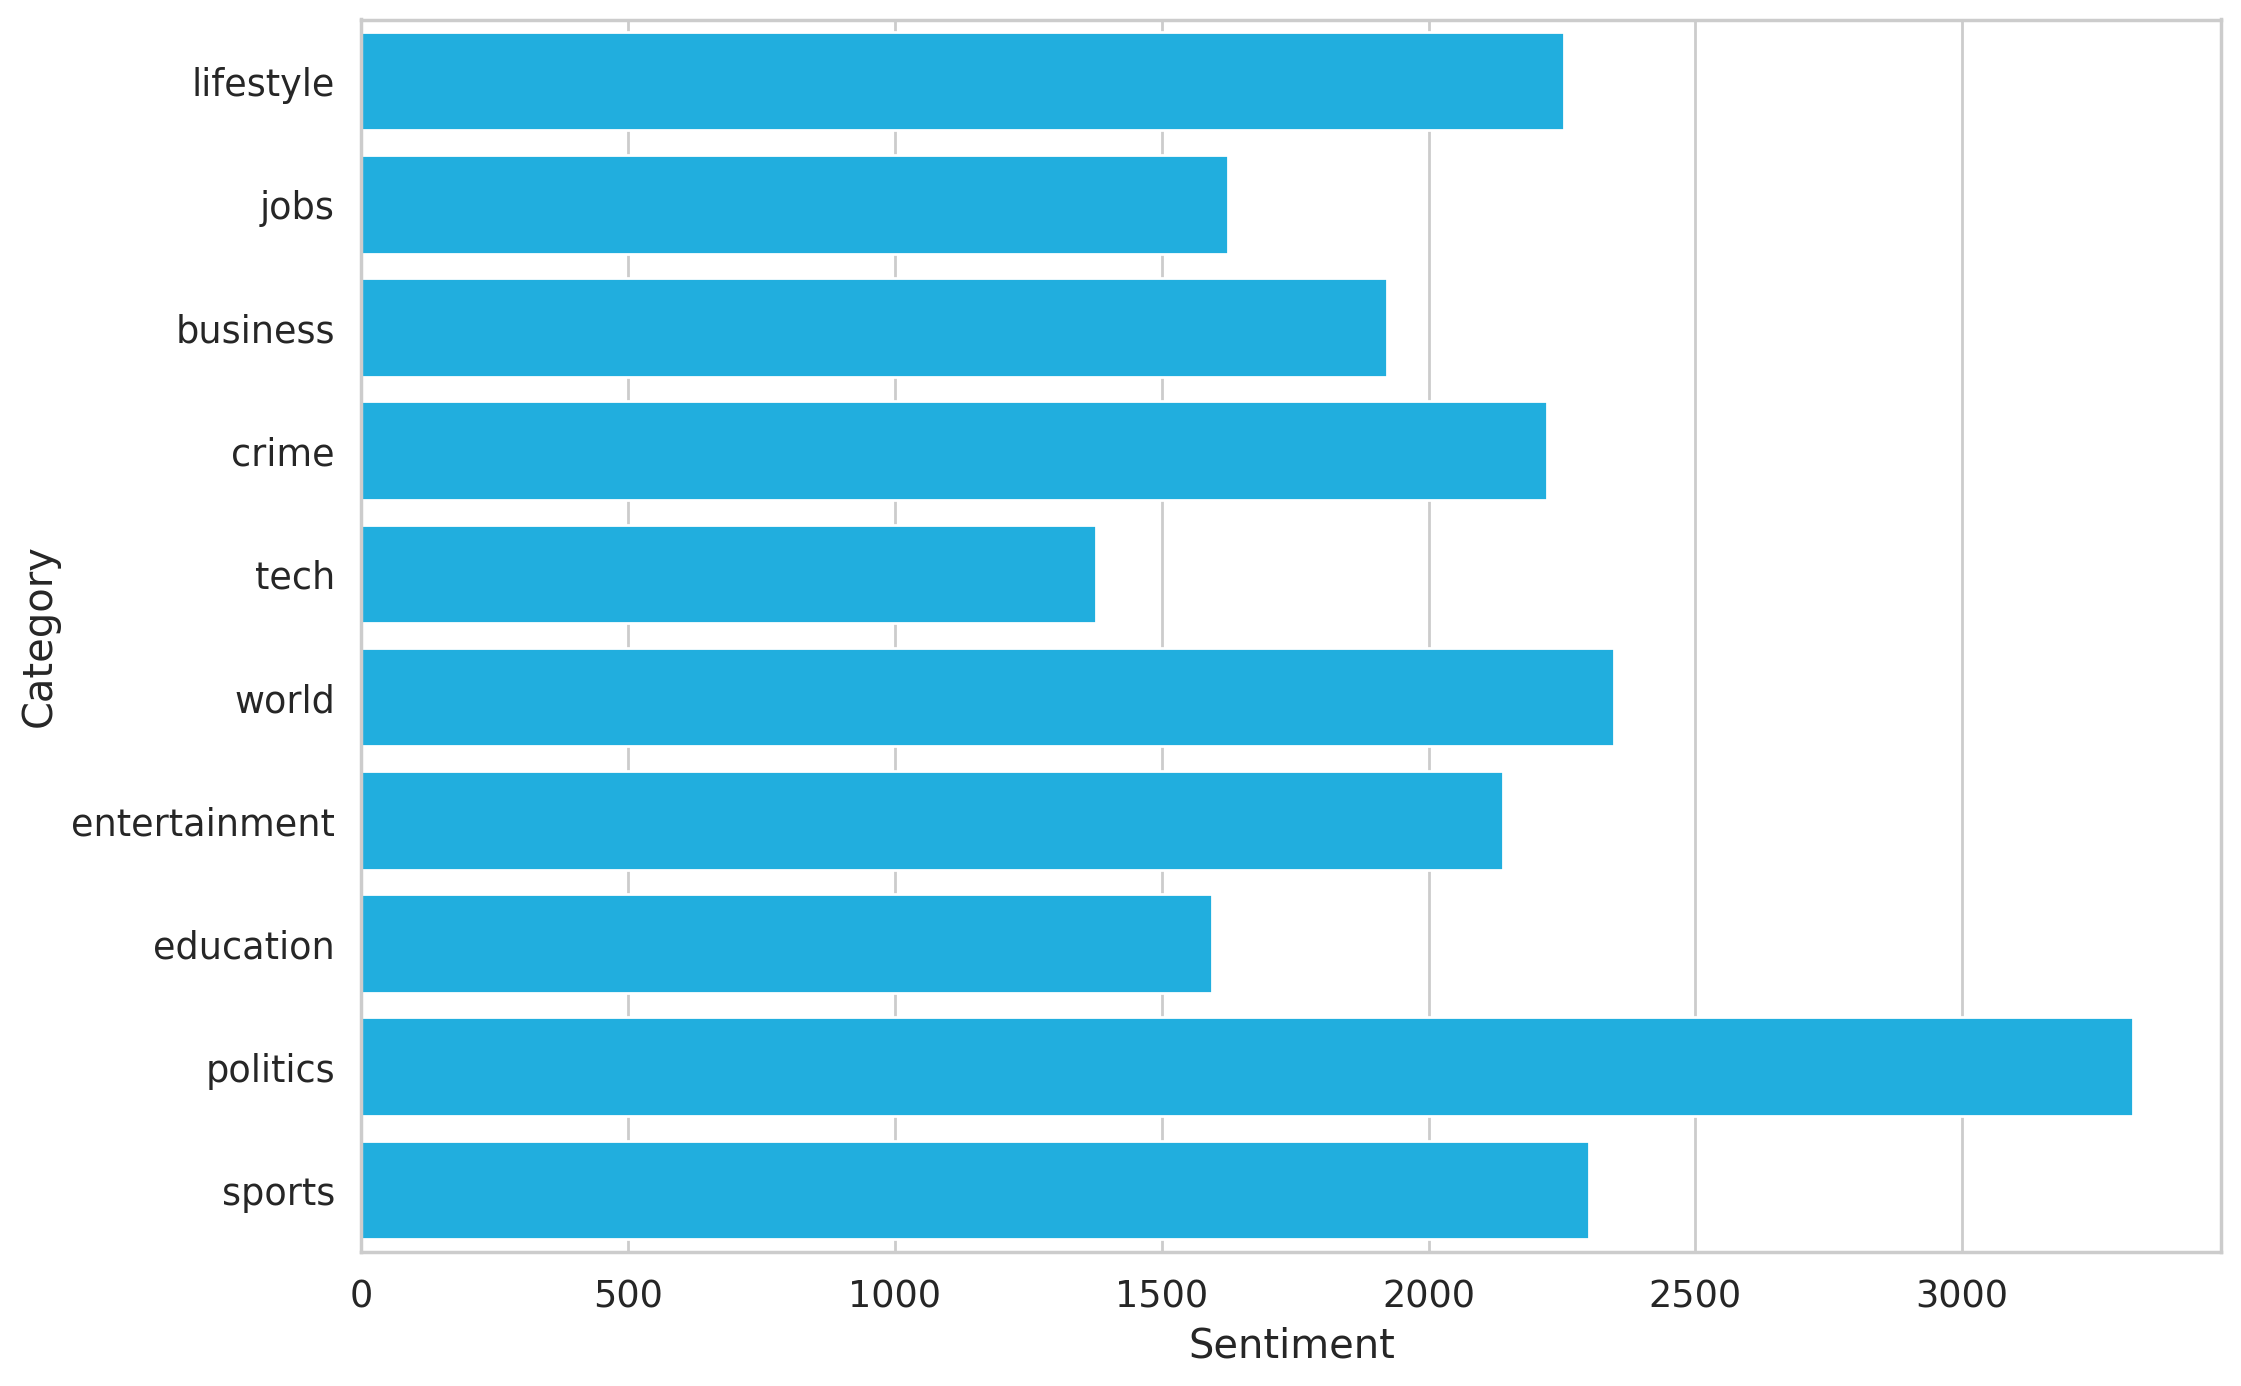

In [ ]:
sns.countplot(df_train.Category)
plt.xlabel('Sentiment')

Text(0.5, 0, 'Sentiment')

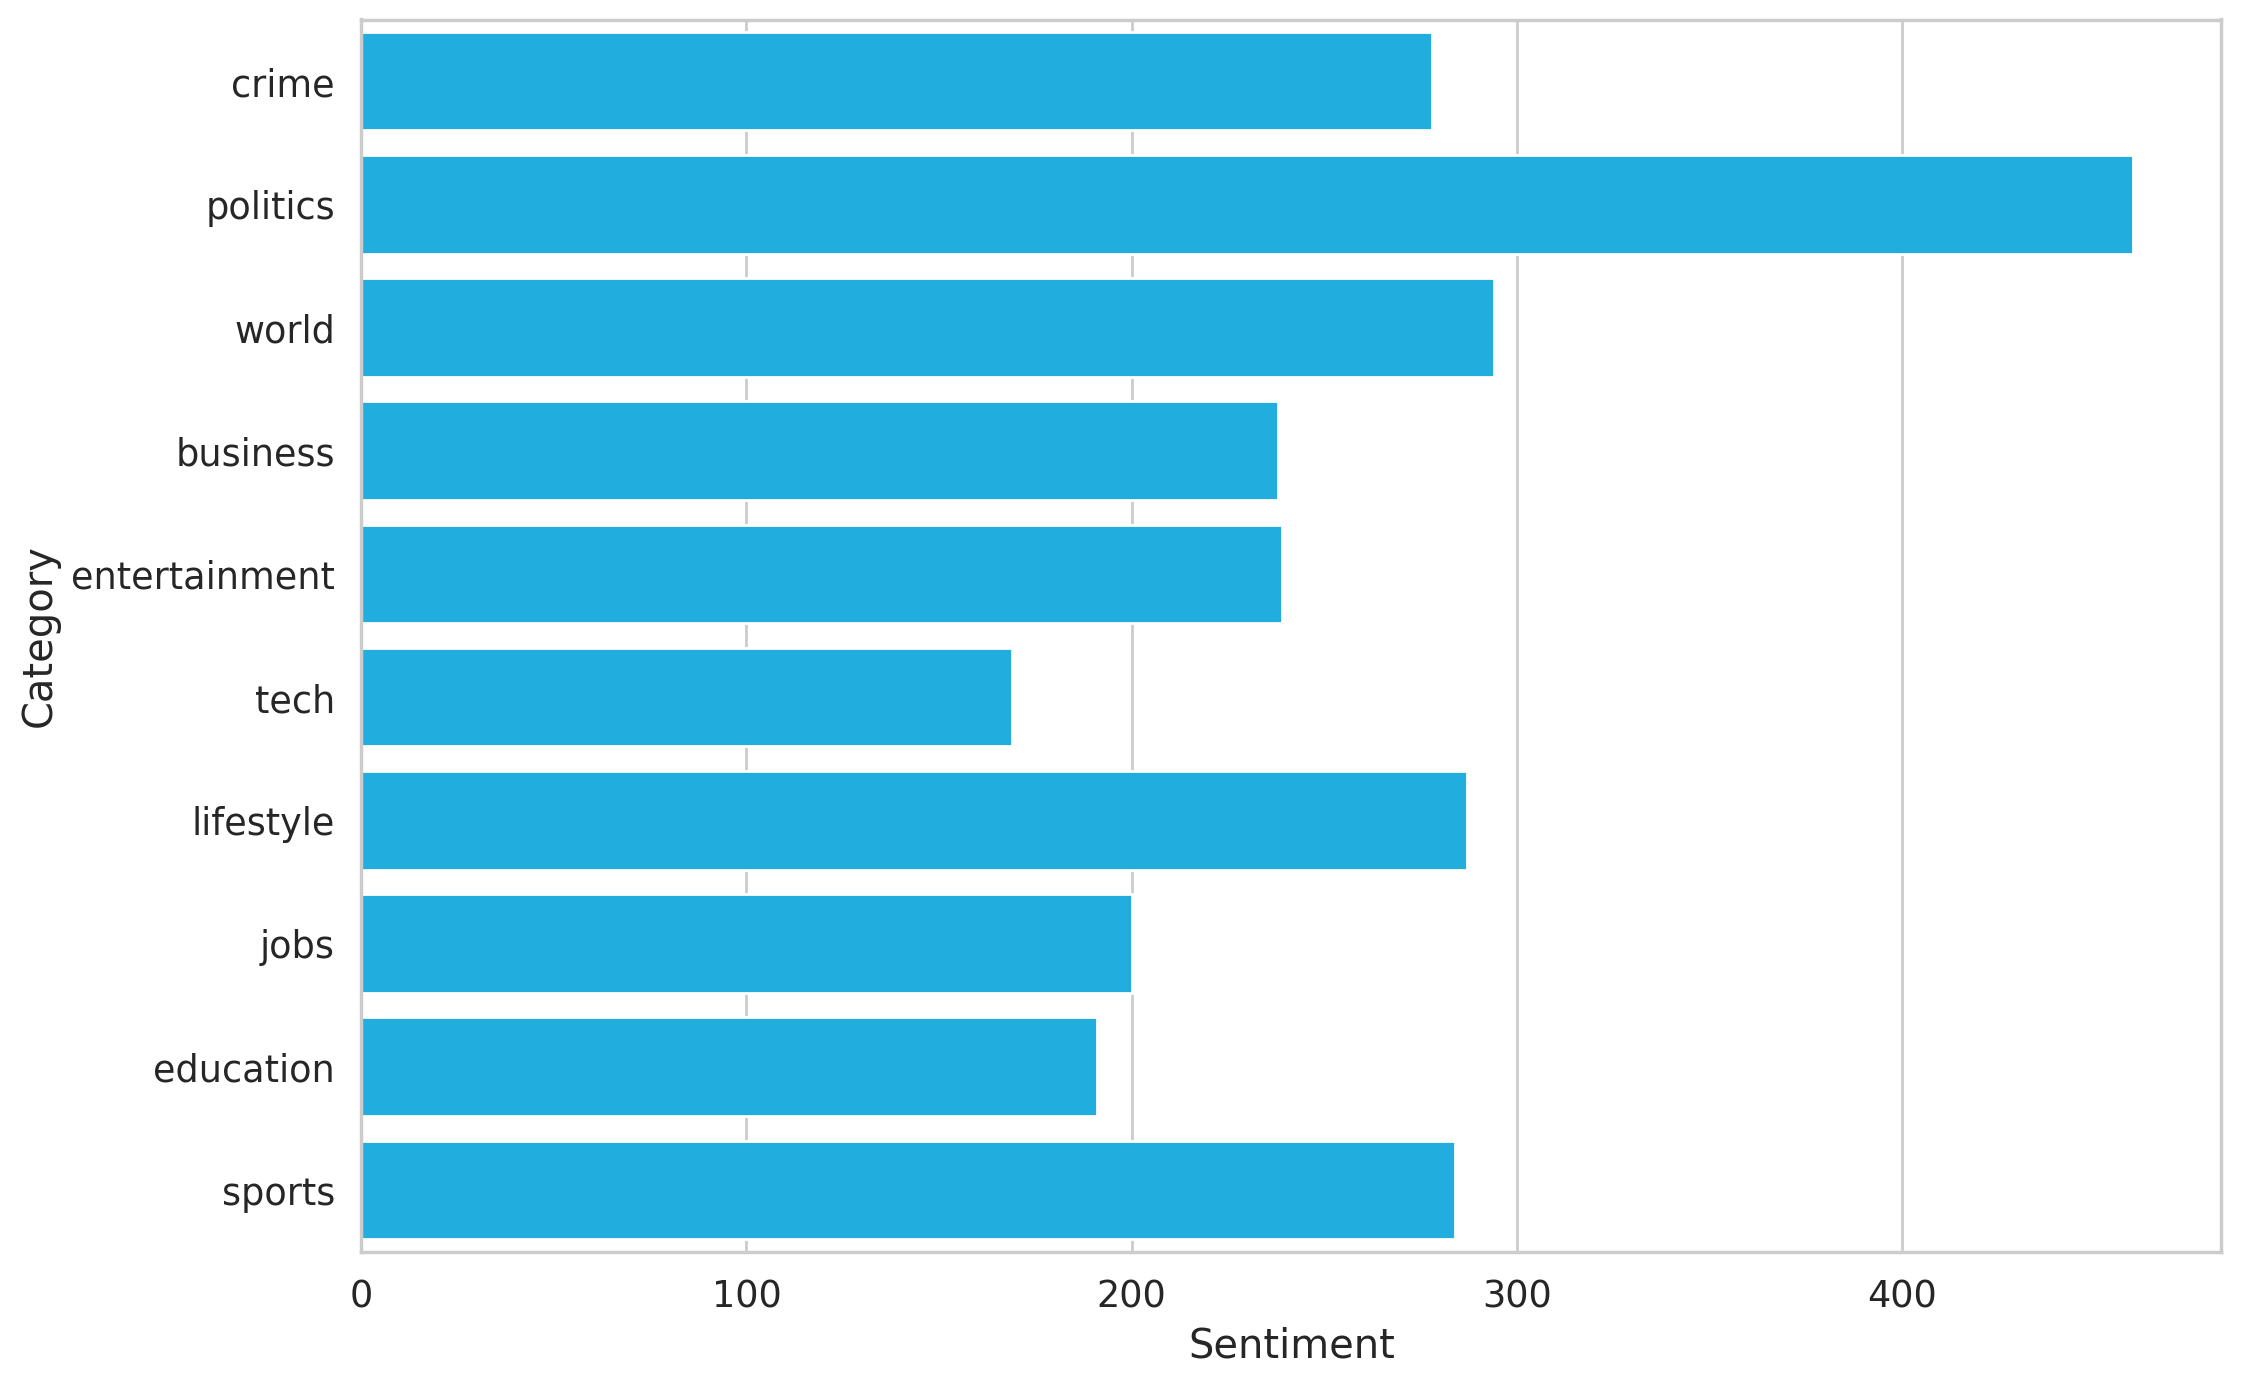

In [ ]:
sns.countplot(df_test.Category)
plt.xlabel('Sentiment')

Text(0.5, 0, 'Sentiment')

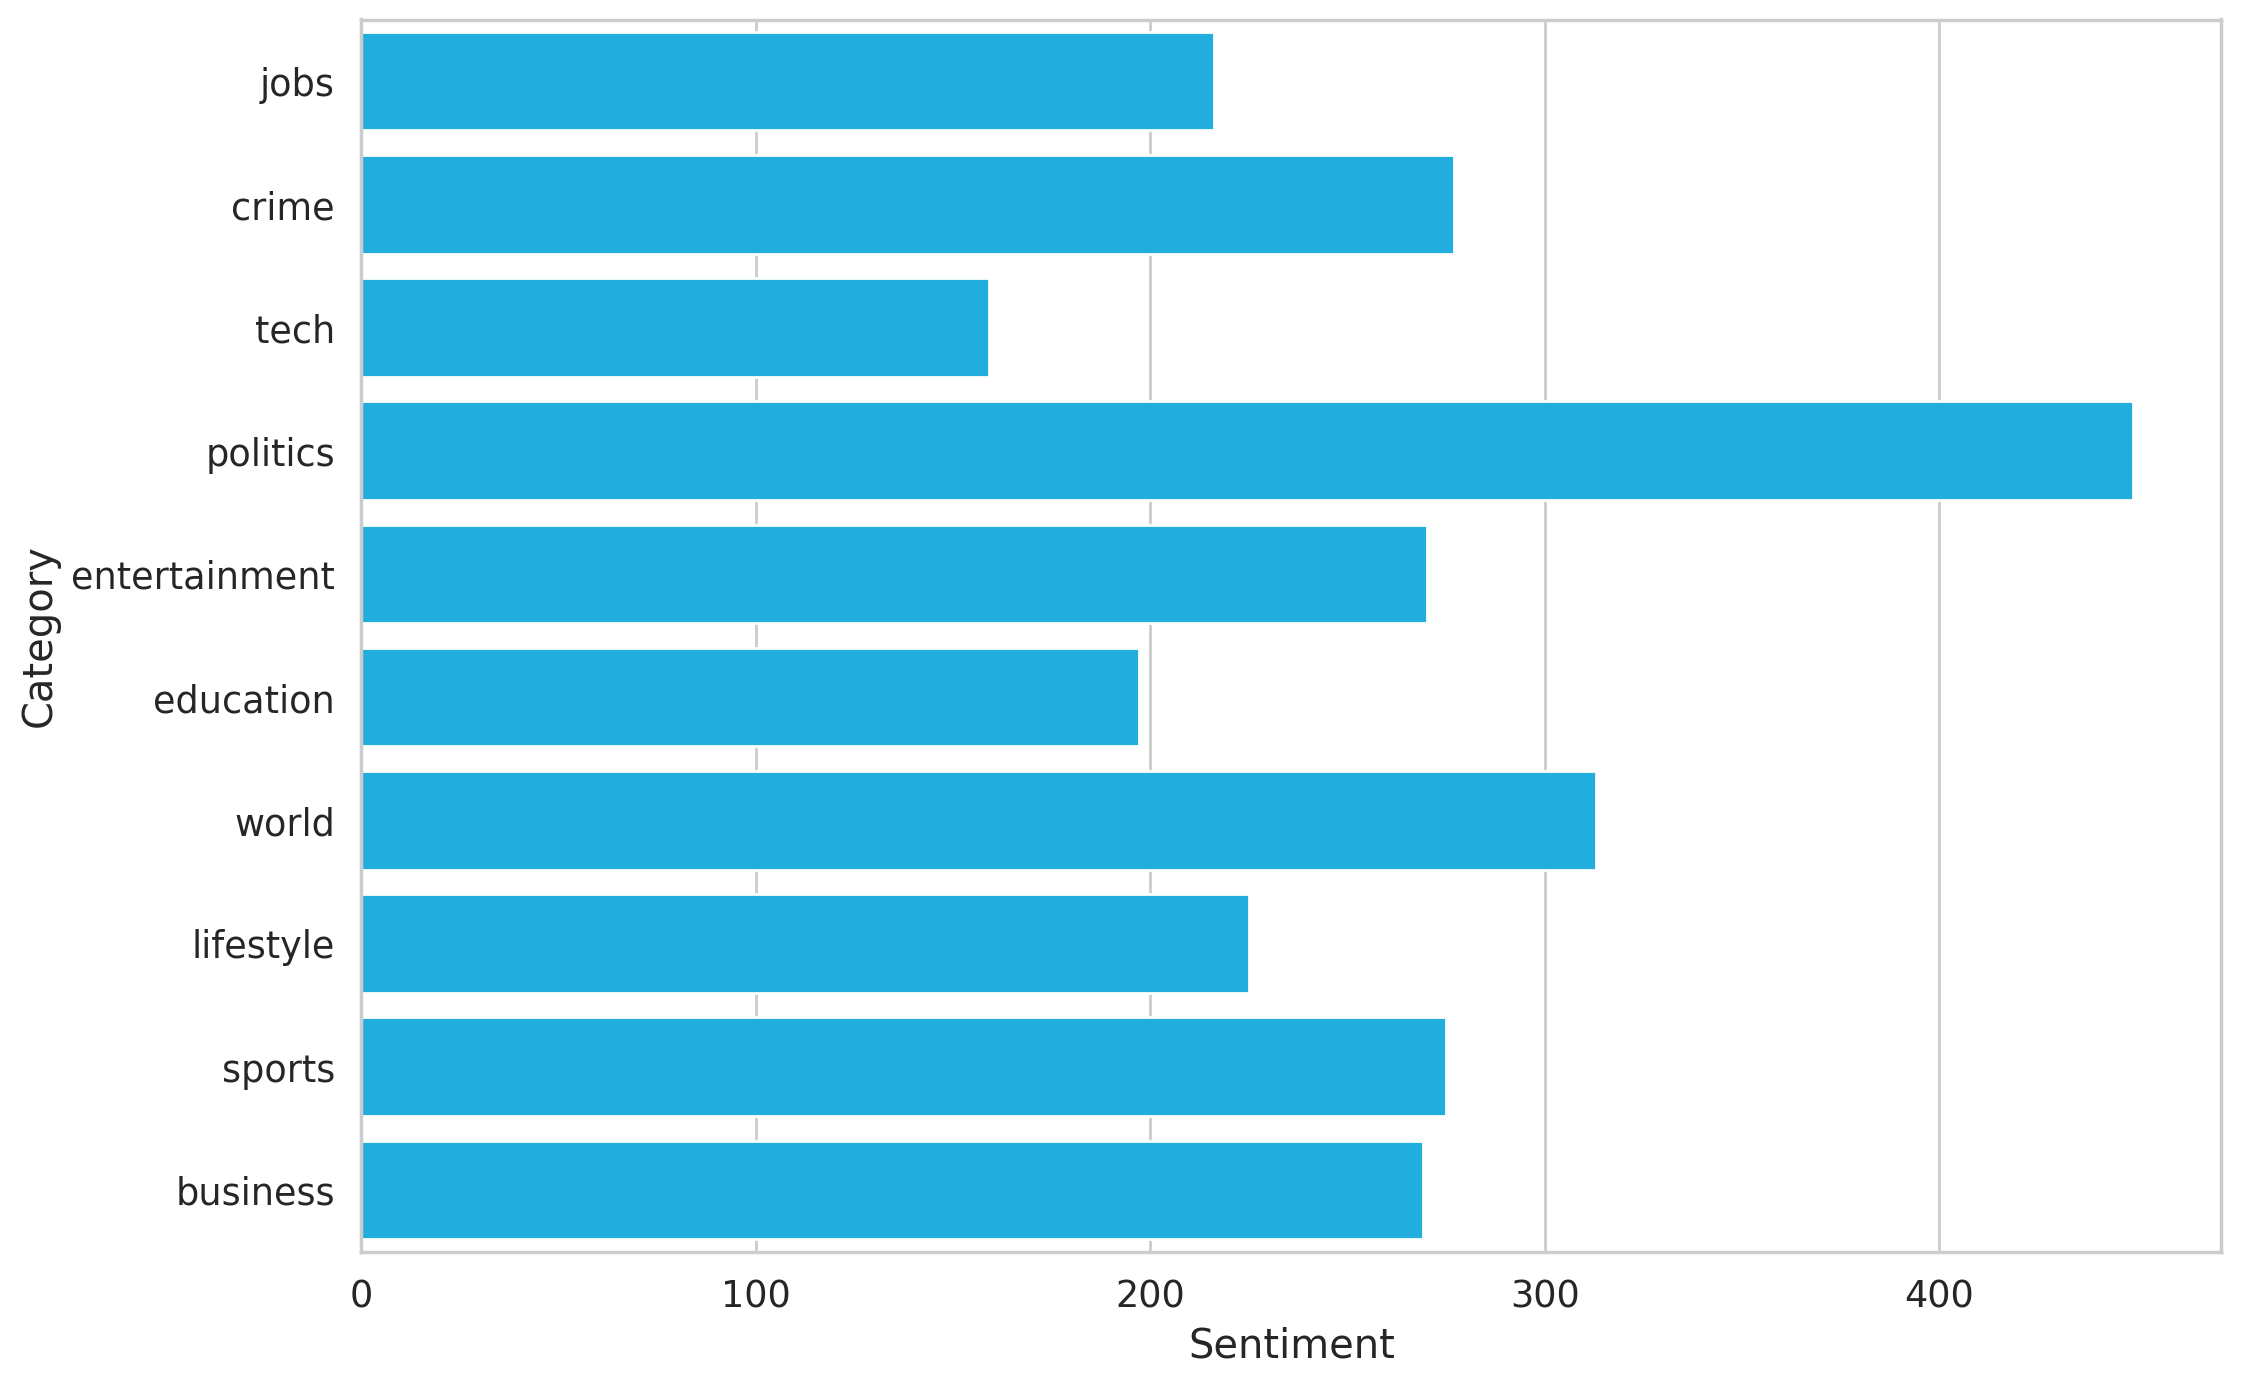

In [ ]:
sns.countplot(df_valid.Category)
plt.xlabel('Sentiment')

In [ ]:
pd.set_option("display.max_colwidth", None)
df_train.head(10)

,Title,Category,News,Sub Article
0,Digestive Biscuits: ఆ బిస్కెట్లు ఆరోగ్యానికి మంచిది కావా? ఏం జరుగుతుంది?,lifestyle,"టీ కప్పుతో పాటు చాలా మంది డైజెస్టివ్ బిస్కెట్స్ కూడా పెట్టుకుని తింటారు. తక్కువ కేలరీలు, అధిక ఫైబర్ ప్రత్యామ్నాయాలుగా ఉండే ఈ కుకీస్ ఆరోగ్యానికి మంచిదని భావిస్తారు. నోట్లో వేసుకుంటేనే కరిగిపోయే విధంగా తక్కువ తీపి రుచిని కలిగి ఉంటాయి. ముతక గోధుమ పిండి, కృత్రిమ రైజింగ్ ఏజెంట్లు, ఉప్పుతో తయారు చేస్తారు. రుచిని బట్టి బిస్కెట్లలో కొన్ని సార్లు ఓట్ మీల్, కల్చర్డ్ స్కిమ్డ్ మిల్క్, గింజల పొడి కూడా కలుపుతారు. ఆకలిని తగ్గించేందుకు, జీర్ణక్రియ మెరుగు పడేందుకు, బరువు తగ్గేందుకు సహాయపడే ఫైబర్ పుష్కలంగా ఉంటుంది. వీటిని తింటే ఆరోగ్యానికి మేలు చేస్తాయని అనుకుంటారు. కానీ ఈ డైజెస్టివ్ బిస్కెట్స్ క్రమం తప్పకుండా తీసుకోవడం వల్ల కొన్ని దుష్ప్రభావాలు ఉన్నాయి.ఆయిల్, మాల్ట్ ఎక్స్ ట్రాక్ట్, రైజింగ్ ఏజెంట్ వంటి పదార్థాలు డైజెస్టివ్ బిస్కెట్స్ లో ఉపయోగిస్తారు. ఆరోగ్య నిపుణుల అభిప్రాయం ప్రకారం ఈ బిస్కెట్లను అతిగా తినడం వల్ల ఎక్కువ హాని చేస్తుంది.డైజెస్టివ్ బిస్కెట్స్ ఎక్కువగా గోధుమలతో తయారవుతాయి. వీటిలో ఇనులిన్ అధికంగా ఉంటుంది. ఈ సమ్మేళనం సహజమైన అరటి పండ్లు, గోధుమలు, ఉల్లిపాయలు, వెల్లుల్లి వంటి అనేక ఇతర ఆహారాల్లో లభించే కార్బోహైడ్రేట్ ఫైబర్. ఇనులిన్ చిన్న పేగుల గుండా పెద్ద పేగుకు వెళుతుంది. అక్కడ అది మంచి బ్యాక్టీరియా పెరుగుదలను ప్రేరేపిస్తుంది.. చాలా మందిలో ఇది గ్యాస్, ఉబ్బరం, ఆపానవాయువు, విరోచనాలకు కారణమవుతుంది. అలాగే మాల్ట్ సారం అధికంగా తీసుకున్నప్పుడు ఆపానవాయువుకు కారణమవుతుంది.ఇందులో వాడే కూరగాయల నూనె ఉడికించినప్పుడు ట్రాన్స్ ఫ్యాట్లను ఉత్పత్తి చేస్తుంది. ఈ ట్రాన్స్ ఫ్యాట్ ఆరోగ్యానికి హానికరం. దగ్గుకు కారణమవుతుంది. జపనీస్ సొసైటీ ఆఫ్ ఇంటర్నల్ మెడిసిన్ నిర్వహించిన ఒక అధ్యయనం ప్రకారం కూరగాయల నూనె లైపోయిడ్ న్యుమోనియాకు కారణమవుతుంది. దీని వల్ల విపరీతమైన దగ్గు వస్తుంది.చాలా మందికి సోడియం బైకార్బొనేట్ వంటి ఏజెంట్లను పెంచడం వల్ల అలర్జీ ఉంటుంది. దీని ఎక్కువగా బిస్కెట్లు, బ్రెడ్లు,బేక్డ్ ఉత్పత్తులలో ఉపయోగిస్తారు. డైజెస్టివ్ బిస్కెట్లు సోడియం బైకార్బోనెట్ లు ఉపయోగిస్తాయి. దీన్ని అతిగా తీసుకుంటే దాహం వేస్తుంది. కడుపు తిమ్మిరి, గ్యాస్ వంటి సమస్యలు ఎదురవుతాయి.ఆరోగ్య నిపుణుల అభిప్రాయం ప్రకారం అధిక రక్తపోటు, గుండె వైఫల్యం లేదా మూత్రపిండాల వ్యాధి వంటి కొన్ని ఆరోగ్య పరిస్థితులు ఉన్న వాళ్ళు డైజెస్టివ్ బిస్కెట్స్ తింటే దుష్ప్రభావాలు ఎక్కువగా ఉంటాయి. సోడియం బైకార్బోనేట్ కడుపును గ్యాస్ ఏర్పరుస్తుంది. పేరుకే డైజెస్టివ్ బిస్కెట్స్ ఆరోగ్యమని అంటారు. కానీ ఇవి కూడా సాధారణ బిస్కెట్స్ మాదిరిగానే మారిపోయాయి. వీటిలో సంతృప్త కొవ్వులు ఉంటాయి. అందుకే వీటిని అతిగా తినడం మంచిది కాదు.గమనిక: పలు అధ్యయనాలు, పరిశోధనల నుంచి సేకరించిన సమాచారాన్ని ఇక్కడ యథావిధిగా అందించాం. ఇది వైద్య నిపుణుల సూచనలకు ప్రత్యామ్నాయం కాదు. తప్పకుండా వైద్యుడు లేదా ఆహార నిపుణుల సలహా తీసుకున్న తర్వాతే ఈ ఆహారాన్ని మీ డైట్‌లో చేర్చుకోవాలి. ఈ సమాచారం కేవలం మీ అవగాహన కోసమే.Also Read: లిప్ స్టిక్ వల్ల పెదాలు నల్లగా మారిపోతున్నాయా? ఇలా చేస్తే ఆ సమస్యే ఉండదు","ఆయిల్, మాల్ట్ ఎక్స్ ట్రాక్ట్, రైజింగ్ ఏజెంట్ వంటి పదార్థాలు డైజెస్టివ్ బిస్కెట్స్ లో ఉపయోగిస్తారు ఆరోగ్య నిపుణుల అభిప్రాయం ప్రకారం ఈ బిస్కెట్లను అతిగా తినడం వల్ల ఎక్కువ హాని చేస్తుందిడైజెస్టివ్ బిస్కెట్స్ ఎక్కువగా గోధుమలతో తయారవుతాయి వీటిలో ఇనులిన్ అధికంగా ఉంటుంది ఈ సమ్మేళనం సహజమైన అరటి పండ్లు, గోధుమలు, ఉల్లిపాయలు, వెల్లుల్లి వంటి అనేక ఇతర ఆహారాల్లో లభించే కార్బోహైడ్రేట్ ఫైబర్ ఇనులిన్ చిన్న పేగుల గుండా పెద్ద పేగుకు వెళుతుంది అక్కడ అది మంచి బ్యాక్టీరియా పెరుగుదలను ప్రేరేపిస్తుంది చాలా మందిలో ఇది గ్యాస్, ఉబ్బరం, ఆపానవాయువు, విరోచనాలకు కారణమవుతుంది అలాగే మాల్ట్ సారం అధికంగా తీసుకున్నప్పుడు ఆపానవాయువుకు కారణమవుతుందిఇందులో వాడే కూరగాయల నూనె ఉడికించినప్పుడు ట్రాన్స్ ఫ్యాట్లను ఉత్పత్తి చేస్తుంది ఈ ట్రాన్స్ ఫ్యాట్ ఆరోగ్యానికి హానికరం దగ్గుకు కారణమవుతుంది"
1,"AIIMS: నాగ్‌పూర్‌ ఎయిమ్స్‌లో 73 సీనియర్‌ రెసిడెంట్ పోస్టులు, అర్హతలివే!",jobs,"నాగ్‌పూర్‌లోని ఆల్ ఇండియా ఇన్‌స్టిట్యూట్ ఆఫ్ మెడికల్ సైన్సెస్(ఎయిమ్స్) వివిధ విభాగాలో ఖాళీగా ఉన్న సీనియర్‌ రెసిడెంట్ పోస్టుల భర్తీకి నోటిఫికేషన్ విడుదల చేసింది. దీనిద్వారా మొత్తం 73 పోస్టులను భర్తీ చేయనున్నారు. సంబంధిత స్పెషలైజేషన్‌లో పీజీ డిగ్రీ ఉత్తీర్ణత ఉన్నవారు దరఖాస్తు చేసుకోవడానికి అర్హులు. సరైన అర్హతలు గల అభ్యర్థులు ఆన్‌లైన్ ద్వారా దరఖాస్తులు సమర్పించాలి. ఈ పోస్టులకి దరఖాస్తు ప్రక్రియ జూన్ 9న ప్రారంభమైంది. జులై 8 వరకు దరఖ

# Preprocessing with transformers

In [ ]:
from transformers import BertTokenizer, BertModel

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-multilingual-cased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
mbert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [ ]:
# sample_txt = 'मेरी आणि सामंथा बस स्थानकावर लवकर पोहोचल्या पण दुपारपर्यंत बसची वाट पाहत बसले'
sample_txt = 'టీ కప్పుతో పాటు చాలా మంది డైజెస్టివ్ బిస్కెట్స్ కూడా పెట్టుకుని తింటారు. తక్కువ కేలరీలు, అధిక ఫైబర్ ప్రత్యామ్నాయాలుగా ఉండే ఈ కుకీస్ ఆరోగ్యానికి మంచిదని భావిస్తారు.'

In [ ]:


tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')



 Sentence: టీ కప్పుతో పాటు చాలా మంది డైజెస్టివ్ బిస్కెట్స్ కూడా పెట్టుకుని తింటారు. తక్కువ కేలరీలు, అధిక ఫైబర్ ప్రత్యామ్నాయాలుగా ఉండే ఈ కుకీస్ ఆరోగ్యానికి మంచిదని భావిస్తారు.
   Tokens: ['ట', '##ీ', 'క', '##ప్', '##పు', '##తో', 'పాటు', 'చాలా', 'మంది', 'డ', '##ై', '##జ', '##ెస్', '##టి', '##వ్', 'బి', '##స్', '##క', '##ెట్', '##స్', 'కూడా', 'ప', '##ెట్', '##టు', '##కుని', 'త', '##ి', '##ంటారు', '.', 'తక్కువ', 'క', '##ే', '##ల', '##రీ', '##లు', ',', 'అ', '##ధిక', 'ఫ', '##ై', '##బర్', 'ప్రత్యామ్నాయ', '##ాలు', '##గా', 'ఉండే', 'ఈ', 'కు', '##క', '##ీ', '##స్', 'ఆరోగ్య', '##ానికి', 'మంచి', '##ద', '##ని', 'భ', '##ా', '##వి', '##స్తారు', '.']
Token IDs: [1210, 18564, 1201, 50445, 23268, 19637, 22095, 44538, 55935, 1212, 34479, 87978, 72799, 23436, 79166, 32523, 15370, 15280, 78820, 15370, 14895, 1220, 78820, 27977, 83997, 1215, 15868, 79350, 119, 101817, 1201, 17729, 13302, 40686, 12164, 117, 1188, 73140, 1221, 34479, 81085, 40134, 20205, 12540, 108746, 1191, 68035, 15280, 18564, 15370, 18557, 

In [ ]:
print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id)
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.unk_token, tokenizer.unk_token_id)

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


In [ ]:


encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32, # Max no. of tokens
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  pad_to_max_length=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()



Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids']

32


tensor([[   101,   1210,  18564,   1201,  50445,  23268,  19637,  22095,  44538,
          55935,   1212,  34479,  87978,  72799,  23436,  79166,  32523,  15370,
          15280,  78820,  15370,  14895,   1220,  78820,  27977,  83997,   1215,
          15868,  79350,    119, 101817,    102]])

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'ట',
 '##ీ',
 'క',
 '##ప్',
 '##పు',
 '##తో',
 'పాటు',
 'చాలా',
 'మంది',
 'డ',
 '##ై',
 '##జ',
 '##ెస్',
 '##టి',
 '##వ్',
 'బి',
 '##స్',
 '##క',
 '##ెట్',
 '##స్',
 'కూడా',
 'ప',
 '##ెట్',
 '##టు',
 '##కుని',
 'త',
 '##ి',
 '##ంటారు',
 '.',
 'తక్కువ',
 '[SEP]']

In [ ]:
token_lens = []
for txt in tqdm(df_train.News):
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

100%|██████████| 21103/21103 [04:21<00:00, 80.81it/s]


<ipython-input-22-696b91674509>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


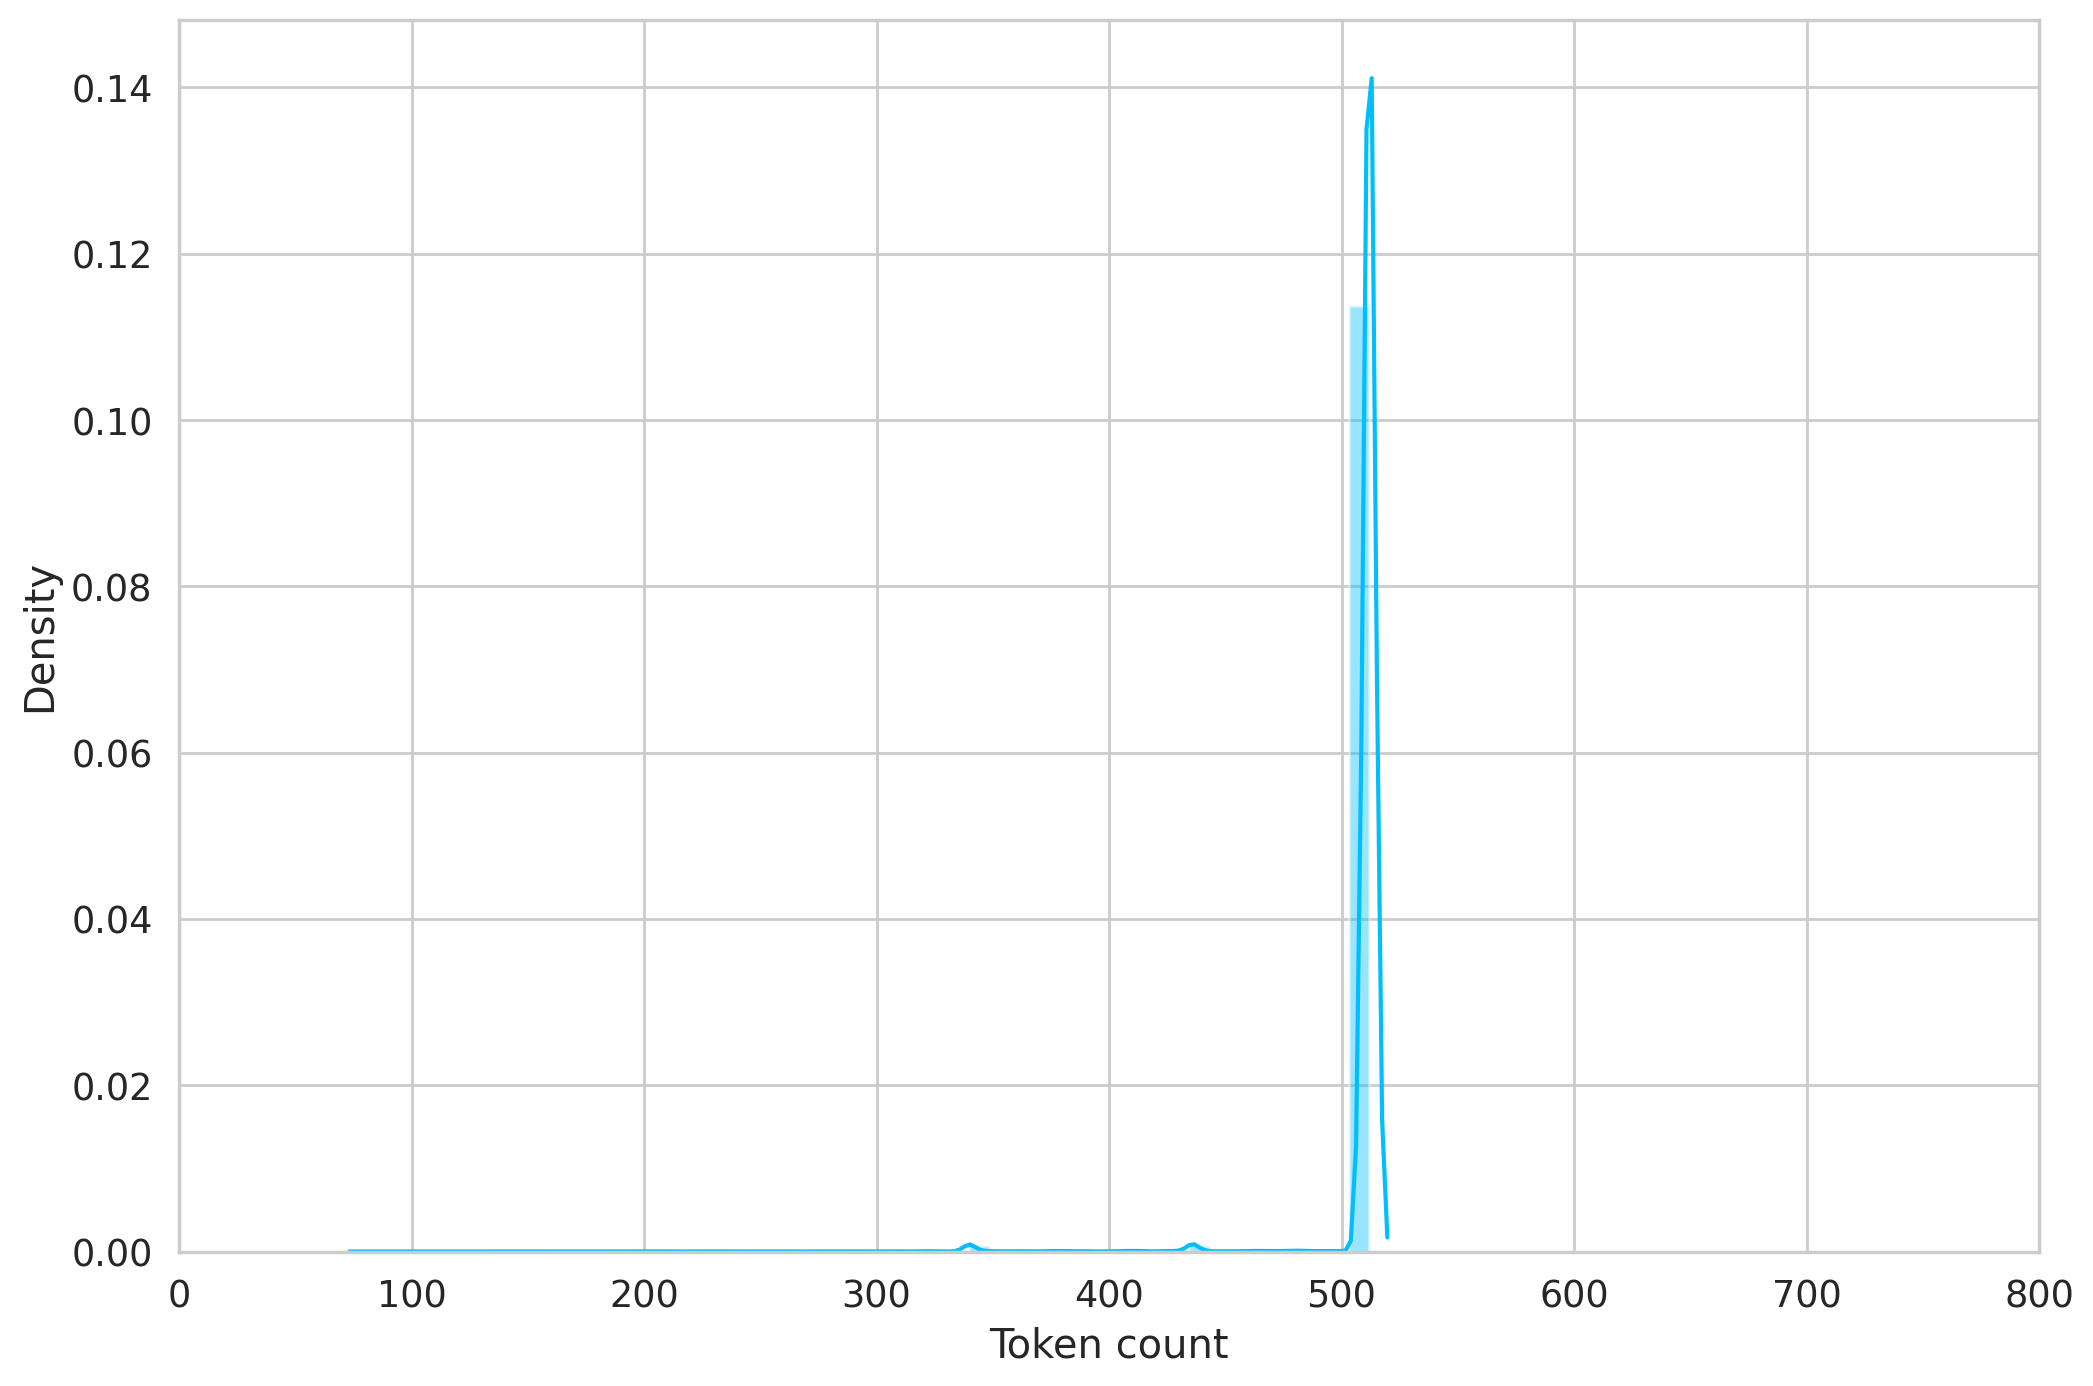

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 800]);
plt.xlabel('Token count');
plt.show()

In [ ]:
encoded_input = encoding
output = mbert_model(**encoded_input)

In [ ]:
output.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

In [ ]:
encoded_input['input_ids'].shape

torch.Size([1, 32])

In [ ]:
MAX_LEN = 160

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, text, targets, tokenizer, max_len):
    self.text = text
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.text)

  def __getitem__(self, item):
    text = str(self.text[item])
    target = self.targets[item]

    encoded_text = self.tokenizer.encode_plus(
      text,
      # add_special_tokens=True,
      max_length=self.max_len,
      padding= 'max_length',
      # pad_to_max_length = True,
      return_tensors='pt',
    )
    # print(self.max_len)

    return {
      'tweet_text': text,
      'input_ids': encoded_text['input_ids'].flatten(),
      'attention_mask': encoded_text['attention_mask'].flatten(),
      'token_type_ids': encoded_text['token_type_ids'].flatten(),
      # 'encoded_text':encoded_text,
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
df_train.shape, df_valid.shape, df_test.shape

((21103, 4), (2650, 4), (2640, 4))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    text=df.News.to_numpy(),
    targets=df.Title.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [ ]:
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_valid, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


In [ ]:
data = next(iter(train_data_loader))
data.keys()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/worker.py", line 309, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<ipython-input-26-f8b5049d167f>", line 32, in __getitem__
    'targets': torch.tensor(target, dtype=torch.long)
TypeError: new(): invalid data type 'str'


In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


# Classification

In [ ]:
encoded_input

In [ ]:
print(encoded_input['attention_mask'] , encoded_input['token_type_ids'])

In [ ]:
encoded_input.keys()

In [ ]:
x = mbert_model(**encoded_input)

In [ ]:
print(x['last_hidden_state'].shape, x['pooler_output'].shape)

In [ ]:
mbert_model.config.hidden_size

In [ ]:

class SentimentClassifier(nn.Module):

  def __init__(self, n_classes, base):
    super(SentimentClassifier, self).__init__()
    self.mbert = base
    self.drop1 = nn.Dropout(p=0.3)
    self.lstm = nn.LSTM(base.config.hidden_size, 150, bidirectional=True, dropout=0.2)
    self.out1 = nn.Linear(300,64)
    self.relu = nn.ReLU()
    self.drop2 = nn.Dropout(p=0.1)
    self.out = nn.Linear(64, n_classes)

  def forward(self,encoded_input):
    x = self.mbert(**encoded_input)
    pooled_output = x['pooler_output']
    # print(pooled_output.shape)
    output = self.drop1(pooled_output)
    # print(output)
    output = output.view(len(output), 1, -1)
    output, _ = self.lstm(output)
    output = output.view(len(output), output.shape[-1])
    output =self.relu(self.out1(output))
    output = self.drop2(output)
    return self.out(output)

In [ ]:

class_names = ['-1','0', '1']
model = SentimentClassifier(len(class_names), mbert_model)
model = model.to(device)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

In [ ]:
len(data['tweet_text'])

In [ ]:

input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
token_type_ids = data['token_type_ids'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length
print(token_type_ids.shape) # batch size x seq_length

In [ ]:
x = mbert_model(**{'input_ids': input_ids, 'attention_mask': attention_mask, 'token_type_ids': token_type_ids})

In [ ]:
x['pooler_output'].shape

In [ ]:
F.softmax(model({'input_ids': input_ids, 'attention_mask': attention_mask, 'token_type_ids': token_type_ids}), dim=1)

In [ ]:
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=1e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in tqdm(data_loader):
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d['token_type_ids'].to(device)
    targets = d["targets"].to(device)
    targets+=1

    outputs = model(
        {
          'input_ids':input_ids,
          'attention_mask':attention_mask,
          'token_type_ids':token_type_ids
        }
    )

    _, preds = torch.max(outputs, dim=1)
    # print('t = ', targets)
    # print('preds = ',preds)

    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)


In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d['token_type_ids'].to(device)
      targets = d["targets"].to(device)
      targets+=1

      outputs = model(
        {
          'input_ids':input_ids,
          'attention_mask':attention_mask,
          'token_type_ids':token_type_ids
        }
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)


In [ ]:

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'\n--> Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_valid)
  )

  print(f'--> Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'm_bert_bilstm_model_state.bin')
    best_accuracy = val_acc


# Results

In [ ]:
for i in range(len(history["train_acc"])):
  history["train_acc"][i]=history["train_acc"][i].cpu()

In [ ]:
for i in range(len(history["val_acc"])):
  history["val_acc"][i]=history["val_acc"][i].cpu()

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([.8, 1]);

# Evaluation

In [ ]:
model2 = SentimentClassifier(len(class_names), mbert_model)
model2.load_state_dict(torch.load('m_bert_bilstm_model_state.bin'))
model2.eval()

In [ ]:
model2 = model2.to(device)

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()

  tweet_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["tweet_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d['type_ids'].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        token_type_ids = token_type_ids
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      tweet_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return tweet_texts, predictions, prediction_probs, real_values

In [ ]:

y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
y_pred-=1

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

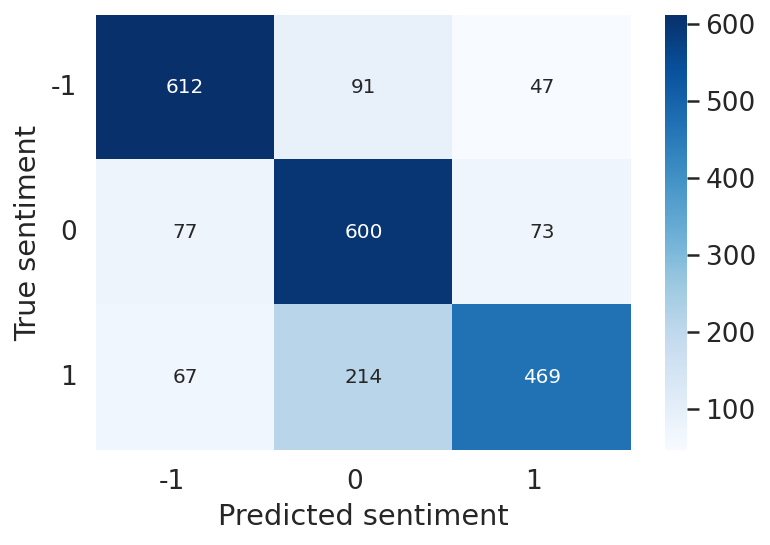

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=0, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
y_test[50:60]

tensor([ 1, -1, -1,  1,  1,  0,  1,  1, -1,  1])

In [ ]:
idx = 50

tweet_text = y_tweet_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})



 आमचे मार्गदर्शक, अहमदनगर शहराचे माजी महापौर व माजी नगराध्यक्ष दीप चव्हाण साहेबांना वाढदिवसाच्या मनःपूर्वक शुभेच्छा 




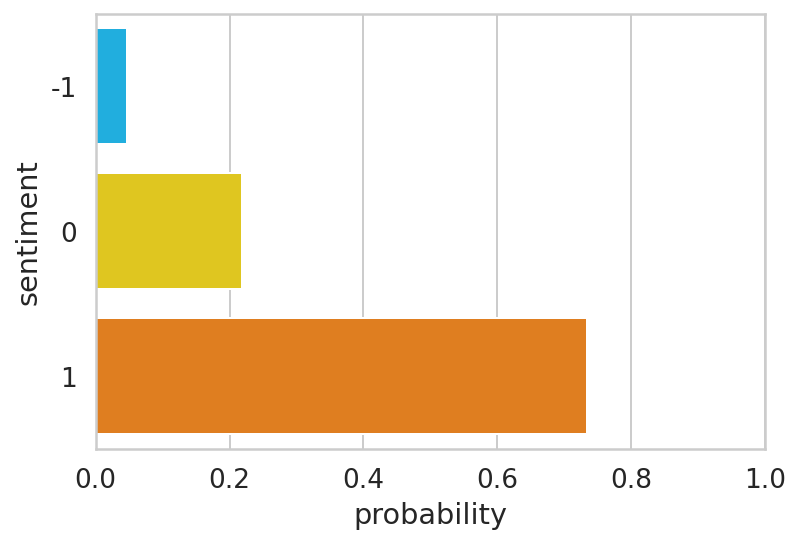

In [ ]:
print('\n\n',tweet_text, '\n\n')

sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [ ]:
y_test[14], y_tweet_texts[14]

# Custom Prediction

In [ ]:
# strip -> punctuations  -> @ mentions delete -> url delete ->  remove # from #-tokens -> stop words delete (no delete )  -> rare words no delete)
def preprocess(line):

  line = line.strip()
  line = re.sub(r'\S*\.com\S*'," ",line)
  line = re.sub(r'\S*\.in\S*'," ",line)
  line = re.sub(r'\S*\.net\S*'," ",line)
  line = re.sub(r'\S*\.me\S*'," ",line)
  line = re.sub(r'\s+:\s+'," ",line)
  line = re.sub(r'\s+-\s+'," ",line)


  line = re.sub(r'/https?\/\/(.*\.(in))\//'," ",line)
  line = re.split(r'\s+|[!$%&()*+./;<=>?\^`{|}~\'\"]\s*', line)
  line = [token.strip() for token in line if token != '' and token != ' ' and token != '\n']

  if len(line) > 1:
    tokens = []
    for i in range(len(line)):
      if line[i][0] == '#':
        tokens.append(line[i][1:])
      elif line[i][0] == '@' or line[i][0] in string.punctuation :
        continue
      else:
        tokens.append(line[i])
    return tokens


In [ ]:
tweet_text = "नमो सरकारला साधी अडचने पार पाडण्याची बुद्धी नाही आहे. एकदम मूर्खपणाचे लक्षण आहे"
tweet_text = "प्रौढ प्रताप पुरंदर, क्षत्रिय कुलावतंस, सिंहासनाधीश्वर, महाराजाधिराज महाराज श्रीमंत श्री छत्रपती शिवाजी महाराज की जय"
tweet_text = "मनाचे वेधना किती सोसावे सामान्य माणसाने"
tweet_text = "माननीय महोदय संजय विचारे यांच्या अपघाताची बातमी आज कळाली. खूप वाईट वाटले."
tweet_text = "नमो सरकारला साधी अडचने पार पाडण्याची बुद्धी नाही आहे. एकदम मूर्खपणाचे लक्षण आहे"
tweet_text = "गढ आला पण माझा सिंह गेला"
tweet_text = "मैदानात हजारो कंडोम पाकीटं कुणी फेकली?; खुलासा होताच अधिकाऱ्यांनी डोक्यावर हात मारला"
tweet_text = "महाशिवरात्रीच्या सर्वांना हार्दिक हार्दिक शुभेच्छा"
tweet_text= "नमो सरकारला साधी अडचने पार पाडण्याची बुद्धी नाही आहे. एकदम मूर्खपणाचे लक्षण आहे"
tweet_text = "हिंदू धर्मात मुलांना लहानपणापासून आपला धर्मग्रंथ गीता शिकवला जात नाही हे सत्य आहे."
tweet_text = "प्रा. यारकुंडकरांसारख्या थोर वयकतीमत्वाचा परिचय देताना, मला आज प्रचंड अभिमान वाटतोय."
tweet_text = preprocess(tweet_text)
tweet_text = " ".join(tweet_text)

In [ ]:

encoded_tweet = tokenizer.encode_plus(
  tweet_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=True,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
input_ids = encoded_tweet['input_ids'].to(device)
attention_mask = encoded_tweet['attention_mask'].to(device)
token_type_ids = encoded_tweet['token_type_ids'].to(device)

output = model(input_ids, attention_mask, token_type_ids)
_, prediction = torch.max(output, dim=1)

print(f'Tweet text: {tweet_text}')
print(f'Sarcasm  : {class_names[prediction]}')

Tweet text: प्रा यारकुंडकरांसारख्या थोर वयकतीमत्वाचा परिचय देताना, मला आज प्रचंड अभिमान वाटतोय
Sarcasm  : 1
